## Load Packages

In [64]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..")

import sys 

import subprocess 

import os
import numpy as np
from importlib import reload 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx 
from tqdm import tqdm

import torch
import torch_geometric as geonn
from torch_geometric.loader import DataListLoader
from torch_geometric.nn import DataParallel


from utilities import solver
from utilities import utils 
from utilities import reader
from utilities import vis

import model_dss as dss
import model_dsgps as dsgps
import model_psignn as psignn

from importlib import reload

# from special_geo import mesh_circle_config as mesh_circle 
from special_geo import build_mesh as msh 
# from special_geo import mesh_square
from special_geo import spec_geo_2 as spc
# from special_geo import mesh_2d

In [52]:
from importlib import reload 

reload(msh)
reload(spc)

RR = 1

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "circle",
            "radius"        : 4.0,
            "hsize"         : 0.08,
            "nb_bound_pts"  : 10,
            "tag_dirichlet" : 101,
            "view"          : True
            }

msh.build_mesh(config)

data_psignn, data_dss = spc.build_data("special_geo/mesh_files/circle", 4)
print(data_psignn)
print(data_dss)

# dictpos = {}
# for i in range(len(data_psignn.pos)):
#     dictpos[i] = np.asarray([data_psignn.pos[i,0].item(), data_psignn.pos[i,1].item()])

# net_data = geonn.utils.to_networkx(data_psignn, to_undirected = False, remove_self_loops=False)
# G = net_data.to_undirected()
# G.remove_edges_from(nx.selfloop_edges(G))
# G.remove_nodes_from(list(nx.isolates(G)))
# d = nx.distance_measures.diameter(G)
# print("Diameter : ", d)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0118062s, CPU 0.012091s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.22516s, CPU 0.226203s)
Info    : 7413 nodes 14817 elements
Info    : Writing 'special_geo/mesh_files/circle/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/circle/mesh.msh'
Data(x=[7405, 1], edge_index=[2, 50121], edge_attr=[50121, 3], y=[7405, 1], pos=[7405, 2], a_ij=[50121, 1], sol=[7405, 1], prb_data=[7405, 2], tags=[7405, 1])
Data(x=[7405, 1], edge_index=[2, 42716], edge_attr=[42716, 1], pos=[7405, 2], edge_attr_norm=[42716, 1], b_prime=[7405, 3], b_prime_norm=[7405, 3], tags=[7405, 1], sol=[7405, 1])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_best_dss = torch.load("results_dss/ckpt/best_model.pt")
ckpt_best_dsgps = torch.load("results_dsgps/ckpt/best_model.pt")
ckpt_best_psignn = torch.load("results_psignn/ckpt/best_model.pt")

In [54]:
reload(spc)
reload(vis)
reload(psignn)

list_sol_ml, list_sol_ex = spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)

Random seed set as 1234
Results for Deep Statistical Solvers
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │    REL(%) │       MAX │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│       7405 │  1.117e-03 │ 2.285e+01 │ 5.675e+01 │ 1.379e+02 │      2.763e-04 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for DSGPS
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │    REL(%) │       MAX │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│       7405 │  9.938e-04 │ 1.001e+01 │ 3.756e+01 │ 5.287e+01 │      1.610e-05 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for PSIGNN
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┯━━━━━━━━━┑
│

In [55]:
sol_dss = list_sol_ml[0]
sol_dsgps = list_sol_ml[1]
sol_psignn = list_sol_ml[2]

sol_ex = list_sol_ex[0]

err_dss = (sol_dss - sol_ex)**2
err_dsgps = (sol_dsgps - sol_ex)**2
err_psignn = (sol_psignn - sol_ex)**2

vmin = np.min([err_dss, err_dsgps, err_psignn])
vmax = np.max([err_dss, err_dsgps, err_psignn])

pos = data_psignn.pos.cpu().numpy()

NameError: name 'pos' is not defined

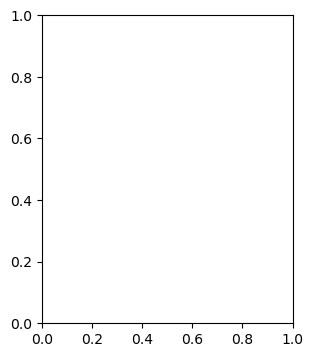

In [63]:
vmin = 0
vmax = 0.5

plt.figure(figsize=[11,4])
plt.subplot(131)
plt.scatter(pos[:,0], pos[:,1], c = err_dss, s = 10, cmap = 'afmhot', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.axis('off')
plt.title("DSS")
plt.subplot(132)
plt.scatter(pos[:,0], pos[:,1], c = err_dsgps, s = 10, cmap = 'afmhot', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.axis('off')
plt.title("DSGPS")
plt.subplot(133)
plt.scatter(pos[:,0], pos[:,1], c = err_psignn, s = 10, cmap = 'afmhot', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.axis('off')
plt.title("PSIGNN")

In [62]:
from importlib import reload 

reload(msh)

r = 7

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "circle",
            "radius"        : r,
            "hsize"         : 0.08,
            "nb_bound_pts"  : 10,
            "tag_dirichlet" : 101,
            "view"          : True
            }

msh.build_mesh(config)

reload(spc)

data_psignn, data_dss = spc.build_data("special_geo/mesh_files/circle", r)
print(data_psignn)
print(data_dss)

spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0148313s, CPU 0.015276s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.636036s, CPU 0.636961s)
Info    : 21213 nodes 42417 elements
Info    : Writing 'special_geo/mesh_files/circle/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/circle/mesh.msh'
Force function :  [ 6.58752761 -7.23051419  1.38942272]
Boundary function :  [-0.44449172 -3.86627043 -8.86785843  8.73670417  8.08007204  4.44470835]
Data(x=[21205, 1], edge_index=[2, 145504], edge_attr=[145504, 3], y=[21205, 1], pos=[21205, 2], a_ij=[145504, 1], sol=[21205, 1], prb_data=[21205, 2], tags=[21205, 1])
Data(x=[21205, 1], edge_index=[2, 124299], edge_attr=[124299, 1], pos=[21205, 2], edge_attr_norm=[124299, 1], b_prime=[21205, 3], b_prime_norm=[21205, 3], tags=[21205, 1], sol=[21205, 1])
Results for Deep Statistical Solvers
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.82 GiB total capacity; 2.59 GiB already allocated; 10.81 MiB free; 2.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
reload(spc)

reload(vis)

spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)

Results for Deep Statistical Solvers
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │       REL │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│       5329 │  2.848e-03 │ 1.369e+02 │ 7.225e-01 │      7.163e-04 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for DSGPS
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │       REL │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│       5329 │  7.186e-03 │ 3.604e+01 │ 3.708e-01 │      3.736e-05 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for PSIGNN
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┯━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │       REL │   MSEDirichlet │   Nstep │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┿━━━━━━━━━┥

(136.8545684814453,
 36.03569793701172,
 1.4320582151412964,
 976,
 0.061408042907714844,
 2.628081798553467,
 6.888925313949585)

In [64]:
reload(spc)
reload(msh)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

radius = [0.6, 1.0, 2.0, 4.0, 5.0, 7.0]

ckpt_best_dss = torch.load("results_dss/ckpt/best_model.pt")
ckpt_best_dsgps = torch.load("results_dsgps/ckpt/best_model.pt")
ckpt_best_psignn = torch.load("results_psignn/ckpt/best_model.pt")

total_dss, total_dsgps, total_psignn = [], [], []
total_nnodes, total_nsteps = [], []
total_clock_dss, total_clock_dsgps, total_clock_psignn = [], [], []

for i in radius:
    
    dssval, dsgpsval, psignnval = [], [], []
    nnodes, psignn_nnsteps = [], []
    dss_clock, dsgps_clock, psignn_clock = [], [], []
    
    for n in range(100):

        np.random.seed(int(n*i + 100))

        torch.cuda.empty_cache()
        
        config = {  "path_mesh"     : "special_geo/mesh_files/",
                    "name_mesh"     : "circle",
                    "radius"        : i,
                    "hsize"         : 0.08,
                    "nb_bound_pts"  : 10,
                    "tag_dirichlet" : 101,
                    "view"          : True
                    }
        
        nb_nodes = msh.build_mesh(config)
        nnodes.append(nb_nodes)
        print(nnodes)

        data_psignn, data_dss = spc.build_data("special_geo/mesh_files/circle", i)

        print(data_psignn)
        print(data_dss)
        
        mse_dss, mse_dsgps, mse_psignn, nsteps_psignn, dss_time, dsgps_time, psignn_time = spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)
        
        dssval.append(mse_dss)
        dsgpsval.append(mse_dsgps)
        psignnval.append(mse_psignn)
        psignn_nnsteps.append(nsteps_psignn)
        dss_clock.append(dss_time)
        dsgps_clock.append(dsgps_time)
        psignn_clock.append(psignn_time)

        torch.cuda.empty_cache()

    total_dss.append(np.mean(dssval))
    total_dsgps.append(np.mean(dsgpsval))
    total_psignn.append(np.mean(psignnval))
    total_nnodes.append(np.mean(nnodes))
    total_nsteps.append(np.mean(psignn_nnsteps))
    total_clock_dss.append(np.mean(dss_clock))
    total_clock_dsgps.append(np.mean(dsgps_clock))
    total_clock_psignn.append(np.mean(psignn_clock))

Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00625121s, CPU 0.006534s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00413364s, CPU 0.004175s)
Info    : 190 nodes 371 elements
Info    : Writing 'special_geo/mesh_files/circle/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/circle/mesh.msh'
[182]
Data(x=[182, 1], edge_index=[2, 1021], edge_attr=[1021, 3], y=[182, 1], pos=[182, 2], a_ij=[1021, 1], sol=[182, 1], prb_data=[182, 2], tags=[182, 1])
Data(x=[182, 1], edge_index=[2, 839], edge_attr=[839, 1], pos=[182, 2], edge_attr_norm=[839, 1], b_prime=[182, 3], b_prime_norm=[182, 3], tags=[182, 1], sol=[182, 1])
Results for Deep Statistical Solvers
Results for DSGPS
Results for PSIGNN
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00793089s, CPU 0.047723s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Dela

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.82 GiB total capacity; 2.58 GiB already allocated; 10.81 MiB free; 2.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [65]:
print(total_dss)
print(total_dsgps)
print(total_psignn)

[0.026934045366942883, 0.010020794812589884, 13.744854003190994, 81.14177465438843, 174.1595458984375]
[0.012357581872493029, 0.30944596230983734, 7.37402206659317, 47.91027879714966, 123.69810485839844]
[0.0029511310858651996, 0.02089917310513556, 0.045519089326262474, 0.7718105316162109, 14.355485677719116]


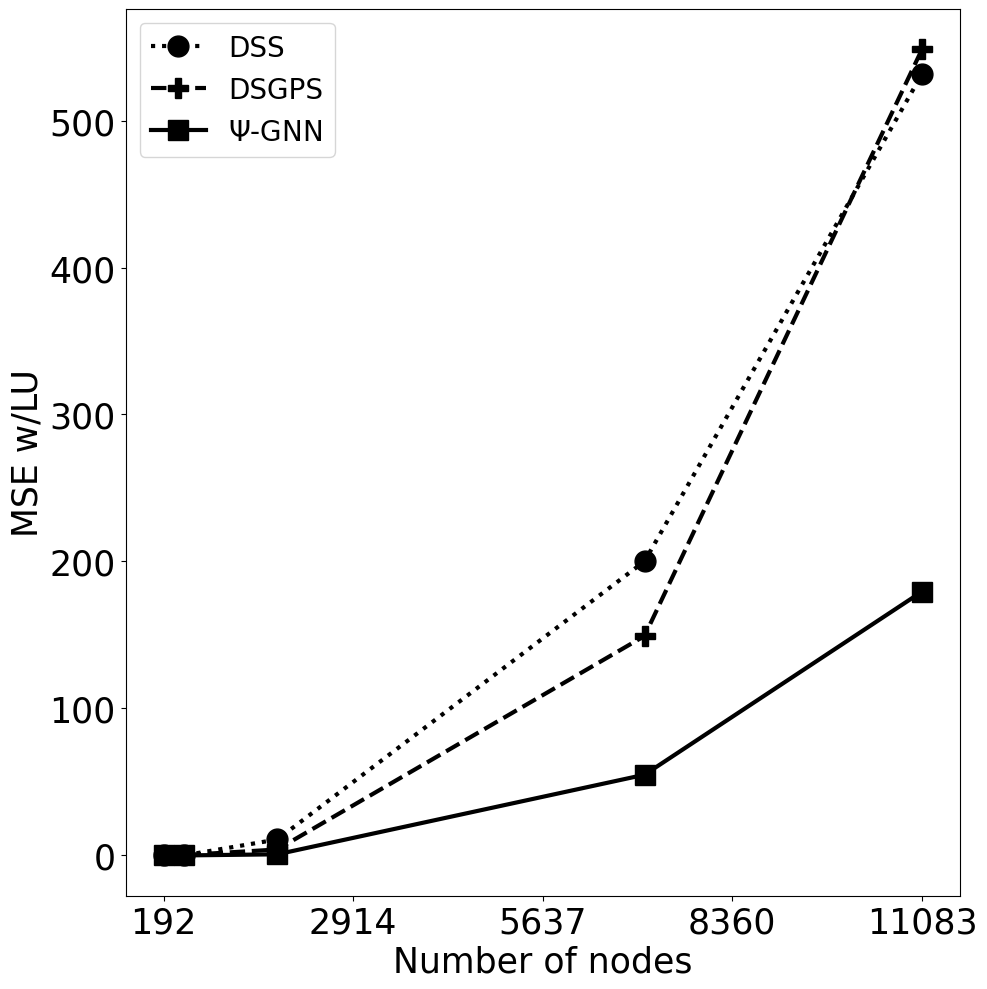

In [5]:
nnodes = [192, 486, 1825, 7099, 11083]

dssval = [0.014, 0.031, 10.85, 200.14, 531.58]
dsgpsval = [0.036, 0.218, 4.047, 149.318, 548.455]
psignnval = [0.006, 0.007, 0.75, 54.9, 179.5]

std_dss = [0.016513751458583907, 0.06127993198630766, 13.85777400341085, 231.4606495712349, 617.885135697143]
std_dsgps = [0.05798500928496141, 0.5102640052717667, 7.2495951636514695, 189.38585111484312, 548.4555803275853]
std_psignn = [0.0047180304754739786, 0.007863101748339514, 6.359390691152374, 88.53801152498583, 276.2599234558063]

plt.figure(figsize = [10,10])
plt.plot(nnodes, dssval, color='black', marker = 'o', linestyle = 'dotted', markersize = 15, linewidth = 3, label = "DSS")
# plt.errorbar(nnodes, dssval, std_dss, linestyle='None', marker='^')

plt.plot(nnodes, dsgpsval, color='black', marker = 'P', linestyle = 'dashed', markersize = 15, linewidth = 3, label = "DSGPS")
# plt.errorbar(nnodes, dsgpsval, std_dsgps, linestyle='None', marker='^')

plt.plot(nnodes, psignnval, color='black', marker = 's', linestyle = 'solid', markersize = 15, linewidth = 3, label = "$\Psi$-GNN")
# plt.errorbar(nnodes, psignnval, std_psignn, linestyle='None', marker='^')

plt.legend(fontsize=20)
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("MSE w/LU", fontsize = 25)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(fontsize = 25)
# plt.yscale("log")
plt.tight_layout()
plt.savefig("img/growing_geometry_comparative_multiple.png", dpi = 500, transparent = True)

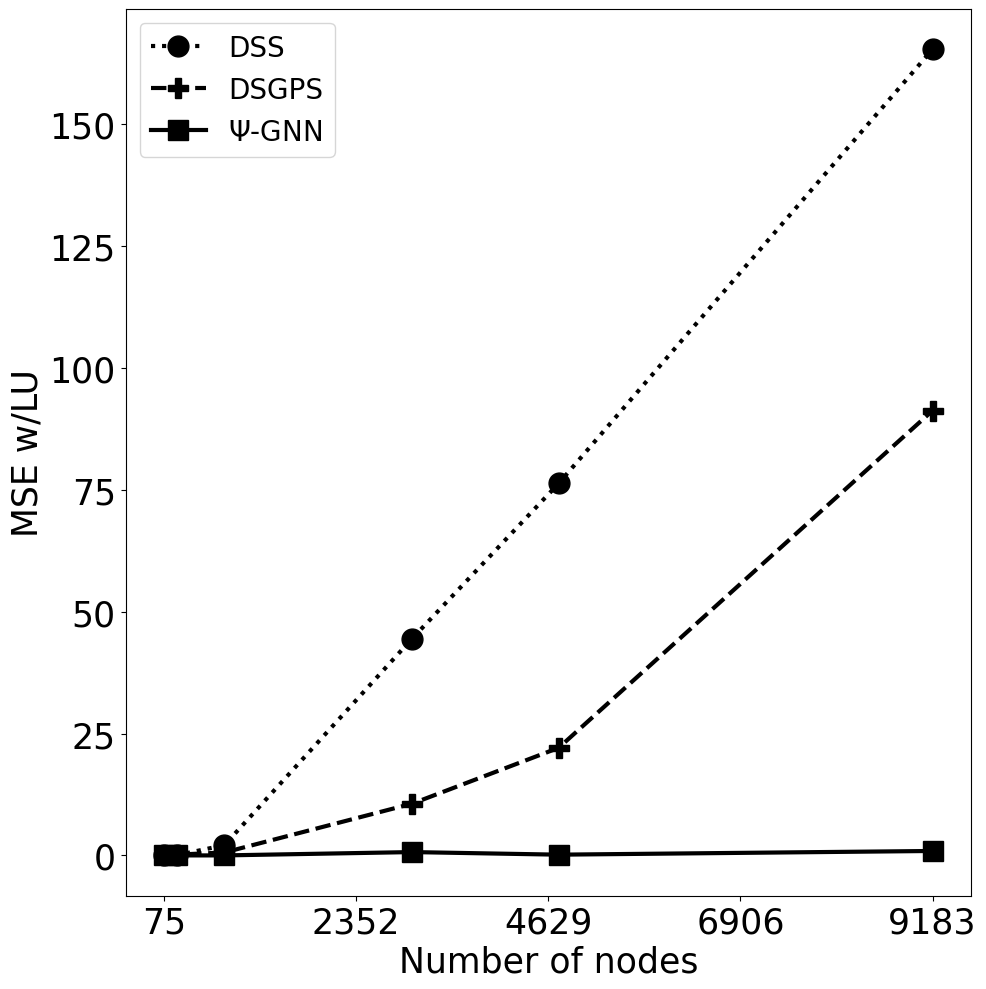

In [12]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, dssval, color='black', marker = 'o', linestyle = 'dotted', markersize = 15, linewidth = 3, label = "DSS")
plt.plot(nnodes, dsgpsval, color='black', marker = 'P', linestyle = 'dashed', markersize = 15, linewidth = 3, label = "DSGPS")
plt.plot(nnodes, psignnval, color='black', marker = 's', linestyle = 'solid', markersize = 15, linewidth = 3, label = "$\Psi$-GNN")
plt.legend(fontsize=20)
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("MSE w/LU", fontsize = 25)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(fontsize = 25)
# plt.yscale("log")
plt.tight_layout()
plt.savefig("img/growing_geometry_comparative.png", dpi = 500, transparent = True)

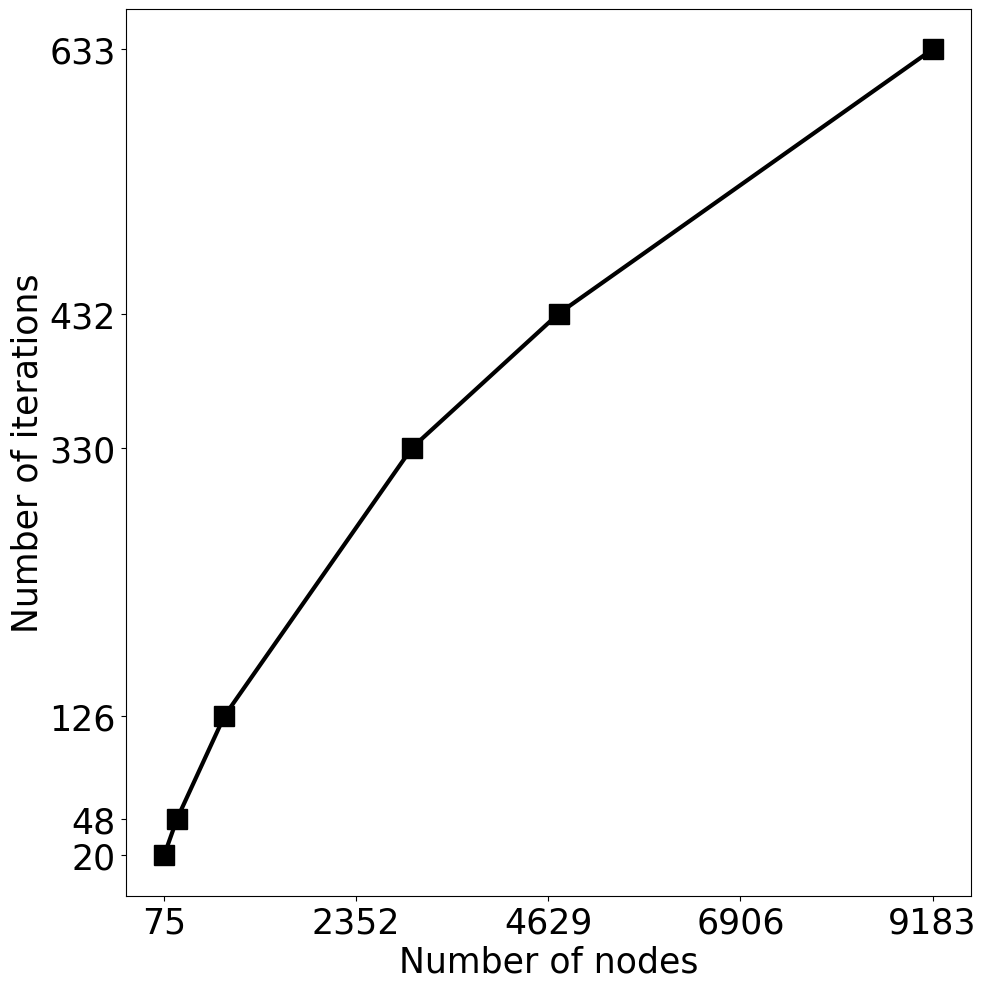

In [13]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, psignn_nnsteps, color = 'black', marker = 's', linestyle = "solid", markersize = 15, linewidth = 3)
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("Number of iterations", fontsize = 25)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(psignn_nnsteps, fontsize = 25)
plt.tight_layout()
plt.savefig("img/growing_geometry_number_of_iterations.png", dpi = 500, transparent = True)

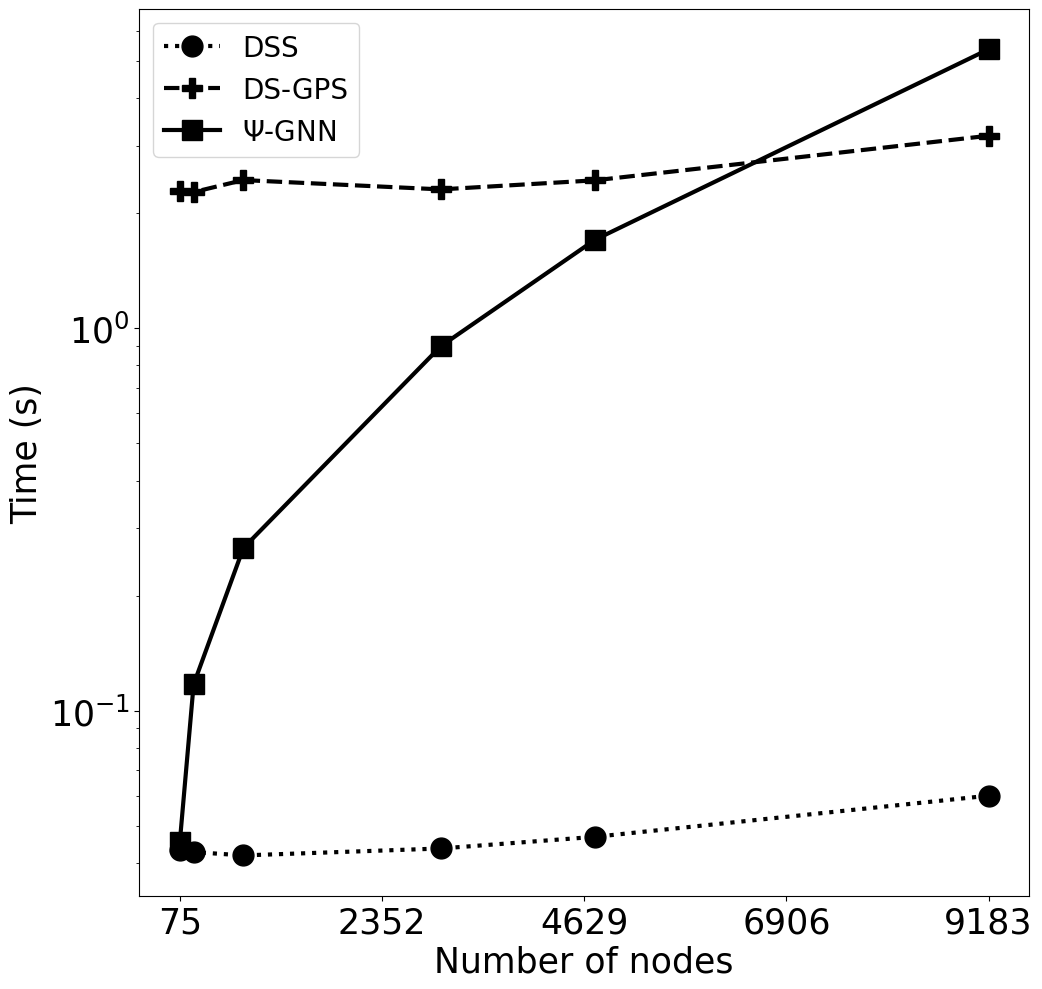

In [16]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, dss_clock, color = 'black', marker = 'o', linestyle = "dotted", markersize = 15, linewidth = 3, label = "DSS")
plt.plot(nnodes, dsgps_clock, color = 'black', marker = 'P', linestyle = "dashed", markersize = 15, linewidth = 3, label = "DS-GPS")
plt.plot(nnodes, psignn_clock, color = 'black', marker = 's', linestyle = "solid", markersize = 15, linewidth = 3, label = '$\Psi$-GNN')
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("Time (s)", fontsize = 25)
plt.legend(fontsize=20)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.yscale('log')
plt.savefig("img/time_inference.png", dpi = 500, transparent = True)

hsize :  0.08
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00904074s, CPU 0.009063s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0126703s, CPU 0.012912s)
Info    : 495 nodes 981 elements
Info    : Writing 'special_geo/mesh_files/original/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/original/mesh.msh'
Data(x=[487, 1], edge_index=[2, 2983], edge_attr=[2983, 3], y=[487, 1], pos=[487, 2], a_ij=[2983, 1], sol=[487, 1], prb_data=[487, 2], tags=[487, 1])
Data(x=[487, 1], edge_index=[2, 2496], edge_attr=[2496, 1], pos=[487, 2], edge_attr_norm=[2496, 1], b_prime=[487, 3], b_prime_norm=[487, 3], tags=[487, 1], sol=[487, 1])
cuda:0
cuda:0
cuda:0


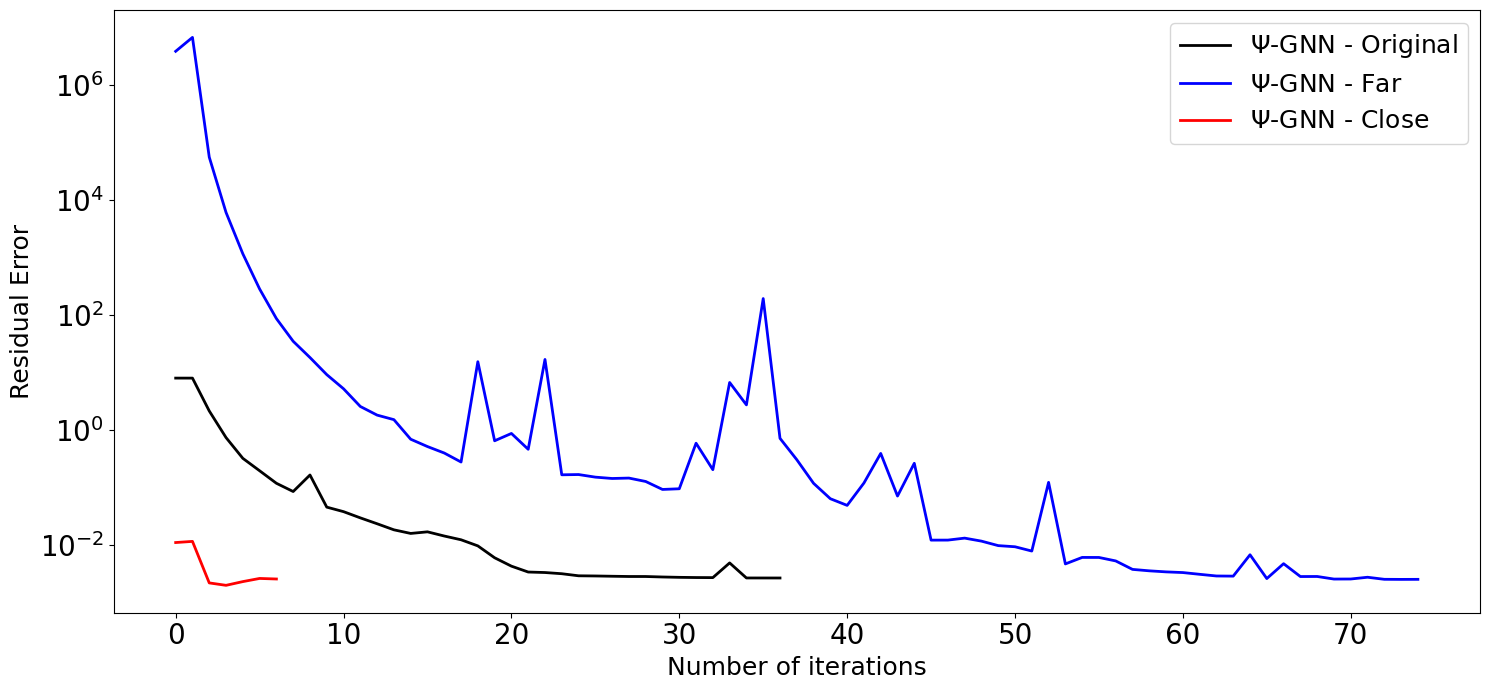

In [126]:
from importlib import reload 
from special_geo import original_mesh
reload(spc)

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "original",
            "hsize"         : 0.08,
            "nb_bound_pts"  : 10,
            "radius"        : 1.0,
            "tag_dirichlet" : 101,
            "view"          : True
            }

original_mesh.build_mesh(config)

data_psignn, data_dss = spc.build_data("special_geo/mesh_files/original", 1.0)

print(data_psignn)
print(data_dss)

dictpos = {}
for i in range(len(data_psignn.pos)):
    dictpos[i] = np.asarray([data_psignn.pos[i,0].item(), data_psignn.pos[i,1].item()])
net_data = geonn.utils.to_networkx(data_psignn, to_undirected = False, remove_self_loops=False)
G = net_data.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
d = nx.distance_measures.diameter(G)

reload(spc)
reload(vis)
res_list = spc.test_several_init(ckpt_best_psignn, data_psignn, device)

originalpsignn = res_list[0]
farpsignn = res_list[1]
closepsignn = res_list[2]

plt.figure(figsize = [15,7])
plt.plot(originalpsignn, color='black', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Original")
plt.plot(farpsignn, color='blue', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Far")
plt.plot(closepsignn, color='red', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Close")
plt.legend(fontsize=18)
plt.xlabel("Number of iterations", fontsize = 18)
plt.ylabel("Residual Error", fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale("log")
plt.tight_layout()
plt.savefig("img/various_initializers.png", dpi = 700, transparent = True)
